In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import seaborn as sns

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tqdm import tqdm

import act_max_util as amu

from autoencoder import *
from solver import *
from model_utils import *

%load_ext autoreload
%autoreload 2

steps = 100               # perform 100 iterations
unit = 0                  # flamingo class of Imagenet
alpha = torch.tensor(100) # learning rate (step size)
verbose = False           # print activation every step
L2_Decay = True           # enable L2 decay regularizer
Gaussian_Blur = False     # enable Gaussian regularizer
Norm_Crop = False         # enable norm regularizer
Contrib_Crop = False      # enable contribution regularizer

In [5]:
dae_model = load_model('/home/david/mnist_model/dae/0/', 'dae', 59)

/home/david/Documents/UNI_LOCAL/developing-autoencoders/model_utils.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"{model_path}/model_weights_ep

In [97]:
data = torch.randn(28, 28)
data = data.unsqueeze(0)
input = data.view(data.size(0), -1)
input.requires_grad_(True)

dae = load_model('/home/david/mnist_model/dae/1/', 'dae', 59)

layer_name = 'bottle_neck'
dae_activation_dictionary = {}

dae.encoder.encoder_3.register_forward_hook(amu.layer_hook(dae_activation_dictionary, layer_name))

dae_rf_ls = []
for i in range(32):
    output = amu.act_max(network=dae,
                    input=input,
                    layer_activation=dae_activation_dictionary,
                    layer_name=layer_name,
                    unit=i,
                    steps=steps,
                    alpha=alpha,
                    verbose=verbose,
                    L2_Decay=L2_Decay,
                    Gaussian_Blur=Gaussian_Blur,
                    Norm_Crop=Norm_Crop,
                    Contrib_Crop=Contrib_Crop,
                    )
    dae_rf_ls.append(output.detach().numpy())

dae_rf_ls = np.array(dae_rf_ls).squeeze()

/home/david/Documents/UNI_LOCAL/developing-autoencoders/model_utils.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"{model_path}/model_weights_ep

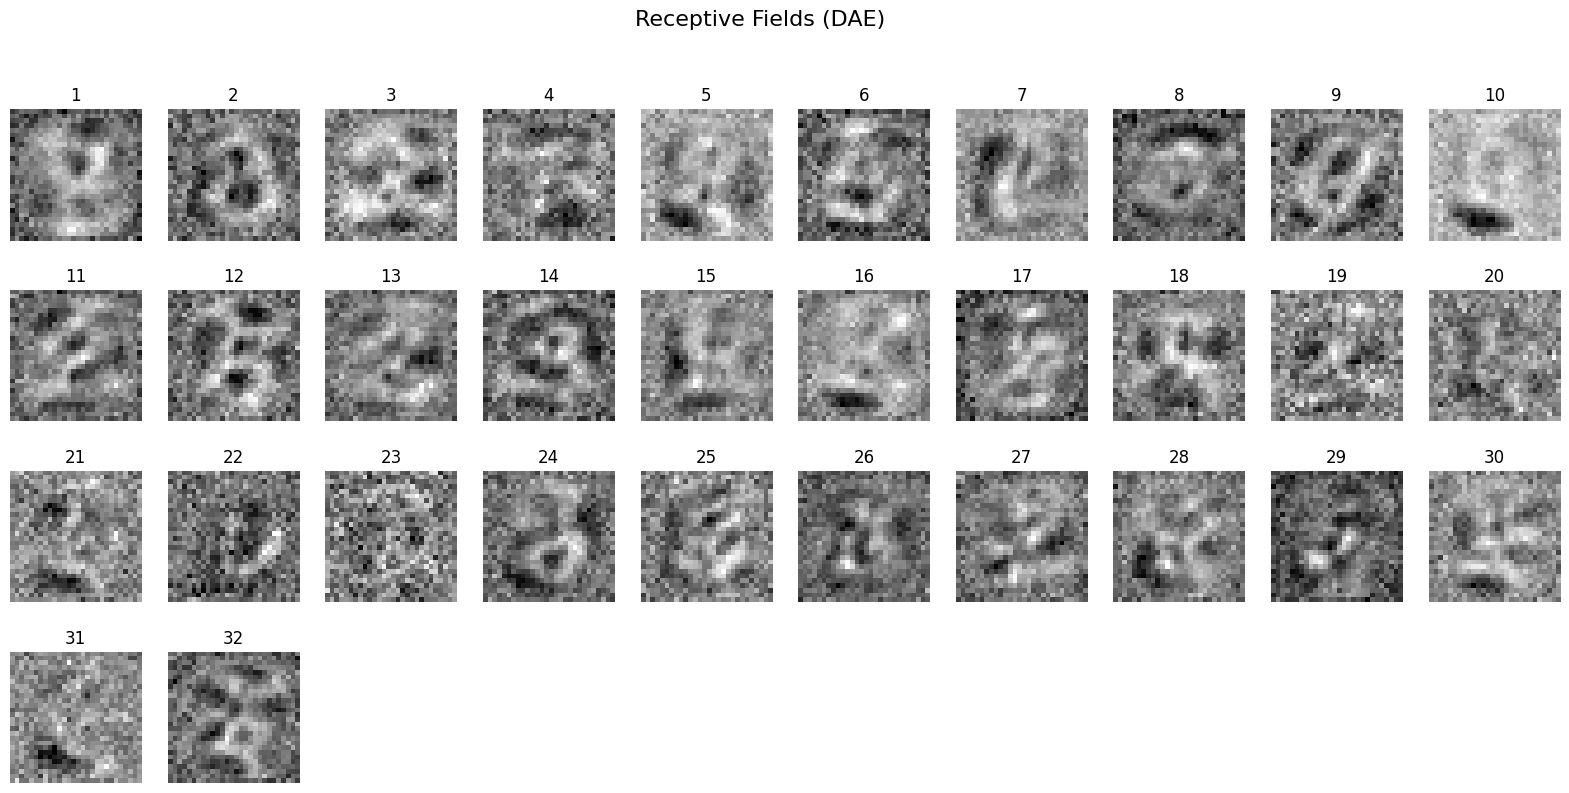

In [98]:
fig = plt.figure(figsize=(20,9))
fig.suptitle("Receptive Fields (DAE)", fontsize=16)
for i in range(32):
    plt.subplot(4,10,i+1)
    plt.title(str(i+1))
    plt.axis('off')
    plt.imshow(dae_rf_ls[i].reshape(28,28),cmap='gray')

In [99]:
neurons_zero_to_three = np.sum(dae_rf_ls[:4], axis=0)
neurons_four_to_nine = np.sum(dae_rf_ls[4:10], axis=0)
neurons_ten_to_fifteen = np.sum(dae_rf_ls[10:16], axis=0)
neurons_sixteen_to_twentythree = np.sum(dae_rf_ls[16:24], axis=0)
neurons_twentyfour_to_thirtyone = np.sum(dae_rf_ls[24:], axis=0)

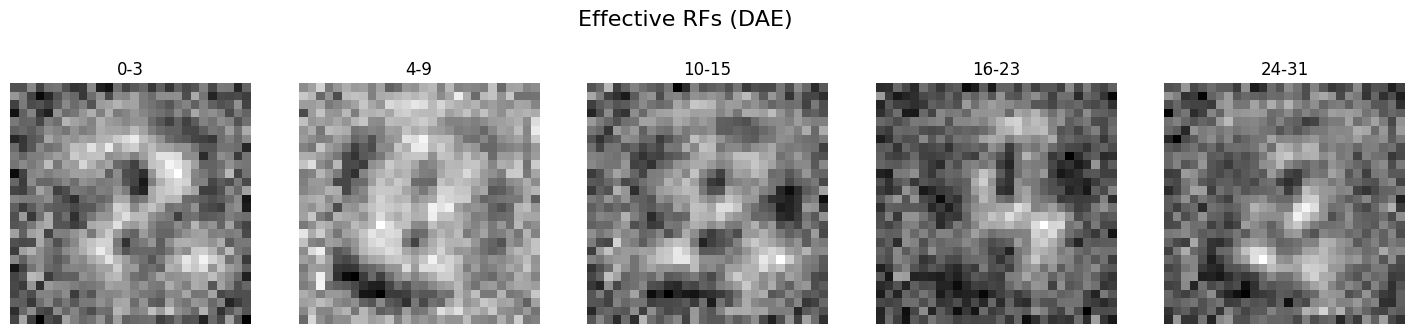

In [100]:
fig = plt.figure(figsize=(18,4))
fig.suptitle("Effective RFs (DAE)", fontsize=16)
plt.subplot(1,5,1)
plt.title('0-3')
plt.axis('off')
plt.imshow(neurons_zero_to_three.reshape(28,28),cmap='gray')

plt.subplot(1,5,2)
plt.title('4-9')
plt.axis('off')
plt.imshow(neurons_four_to_nine.reshape(28,28),cmap='gray')

plt.subplot(1,5,3)
plt.title('10-15')
plt.axis('off')
plt.imshow(neurons_ten_to_fifteen.reshape(28,28),cmap='gray')

plt.subplot(1,5,4)
plt.title('16-23')
plt.axis('off')
plt.imshow(neurons_sixteen_to_twentythree.reshape(28,28),cmap='gray')

plt.subplot(1,5,5)
plt.title('24-31')
plt.axis('off')
plt.imshow(neurons_twentyfour_to_thirtyone.reshape(28,28),cmap='gray')

In [18]:
def weighted_rf_sum(start_idx, end_idx):
    weighted_rf = np.zeros(784)

    with torch.no_grad():
        for idx in range(start_idx, end_idx+1):
            encoded = dae.forward(torch.tensor(dae_rf_ls[idx]), return_activations=True)[2]['encoder_encoder_3'].detach().numpy()
            all_activations_from_rf_i = encoded

            total_activations = np.sum(np.abs(all_activations_from_rf_i))
            neuron_i_activation_from_rf_i = np.abs(all_activations_from_rf_i[idx])
            weighted_rf += neuron_i_activation_from_rf_i / total_activations * dae_rf_ls[idx]

    return weighted_rf.reshape(28, 28)

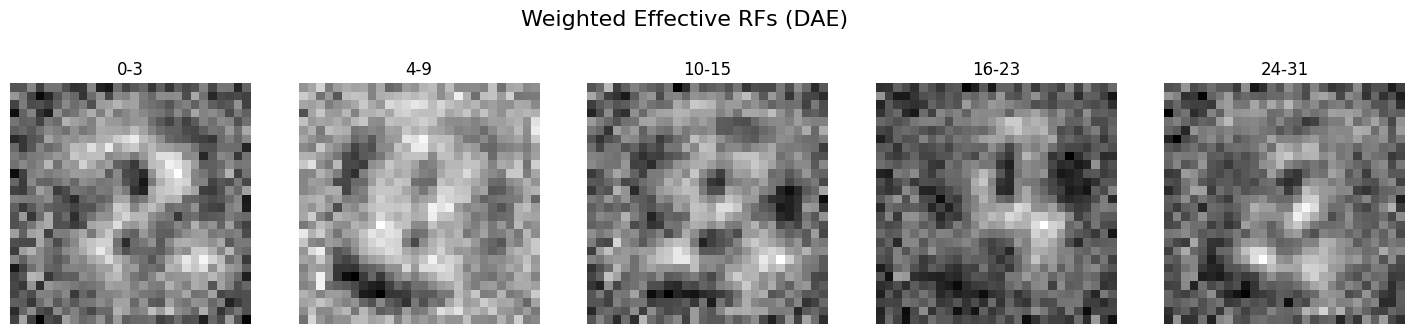

In [101]:
fig = plt.figure(figsize=(18,4))
fig.suptitle("Weighted Effective RFs (DAE)", fontsize=16)
plt.subplot(1,5,1)
plt.title('0-3')
plt.axis('off')
plt.imshow(weighted_rf_sum(0, 3),cmap='gray')

plt.subplot(1,5,2)
plt.title('4-9')
plt.axis('off')
plt.imshow(weighted_rf_sum(4, 9),cmap='gray')

plt.subplot(1,5,3)
plt.title('10-15')
plt.axis('off')
plt.imshow(weighted_rf_sum(10, 15),cmap='gray')

plt.subplot(1,5,4)
plt.title('16-23')
plt.axis('off')
plt.imshow(weighted_rf_sum(16, 23),cmap='gray')

plt.subplot(1,5,5)
plt.title('24-31')
plt.axis('off')
plt.imshow(weighted_rf_sum(24, 31),cmap='gray')

In [4]:
def z_score(image):
    """
    Normalize an image using the z-score normalization.
    Normalized image: (pixel - mean) / std
    """
    mean = np.mean(image)
    std = np.std(image)
    normalized_image = (image - mean) / std
    return normalized_image

def radial_profile(data, center=None):
    """
    Compute the radial profile of a 2D array data.
    """
    y, x = np.indices((data.shape))
    if center is None:
        center = np.array([(x.max() - x.min()) / 2.0, (y.max() - y.min()) / 2.0])

    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())

    radialprofile = tbin / nr

    return radialprofile

def power_spectrum_radial_average(image):
    """
    Calculate the radial average of the power spectrum for a 2D grey-scale image.
    :param image: 2D numpy array representing the image
    :return: radial average of the power spectrum
    """
    # Take the 2D Fourier transform of the image and shift the zero frequency component to the center
    f_transform = np.fft.fftshift(np.fft.fft2(image))

    # Compute the power spectrum (magnitude squared of the Fourier coefficients)
    power_spectrum = np.abs(f_transform) ** 2

    # Compute the radial profile of the power spectrum
    radial_avg = radial_profile(power_spectrum)

    return radial_avg

In [11]:
sae_rf_all = np.load('Saved_Results/sae_rf_all.npy')
dae_rf_all = np.load('Saved_Results/dae_rf_all.npy')

In [12]:
sae_power_spectra = []
for i in range(len(sae_rf_all)):
    rf = sae_rf_all[i]

    sae_power_spectrum = []
    weighted_rfs = [np.sum(np.abs(rf[:4]), axis=0) / 4, np.sum(np.abs(rf[4:10]), axis=0) / 6, np.sum(np.abs(rf[10:16]), axis=0) / 6, np.sum(np.abs(rf[16:24]), axis=0) / 8, np.sum(np.abs(rf[24:]), axis=0) / 8]
    for weighted_rf in weighted_rfs:
        radial_avg = power_spectrum_radial_average(z_score(weighted_rf.reshape(28, 28)))
        sae_power_spectrum.append(radial_avg)

    sae_power_spectra.append(sae_power_spectrum)

sae_power_spectra = np.array(sae_power_spectra)

In [13]:
dae_power_spectra = []
for i in range(len(dae_rf_all)):
    rf = dae_rf_all[i]

    dae_power_spectrum = []
    weighted_rfs = [np.sum(np.abs(rf[:4]), axis=0) / 4, np.sum(np.abs(rf[4:10]), axis=0) / 6, np.sum(np.abs(rf[10:16]), axis=0) / 6, np.sum(np.abs(rf[16:24]), axis=0) / 8, np.sum(np.abs(rf[24:]), axis=0) / 8]
    for weighted_rf in weighted_rfs:
        radial_avg = power_spectrum_radial_average(z_score(weighted_rf.reshape(28, 28)))
        dae_power_spectrum.append(radial_avg)

    dae_power_spectra.append(dae_power_spectrum)

dae_power_spectra = np.array(dae_power_spectra)

/tmp/ipykernel_25345/935073536.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([0, 1, 2, 3, 4, 5])
/tmp/ipykernel_25345/935073536.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([0, 1, 2, 3, 4, 5])


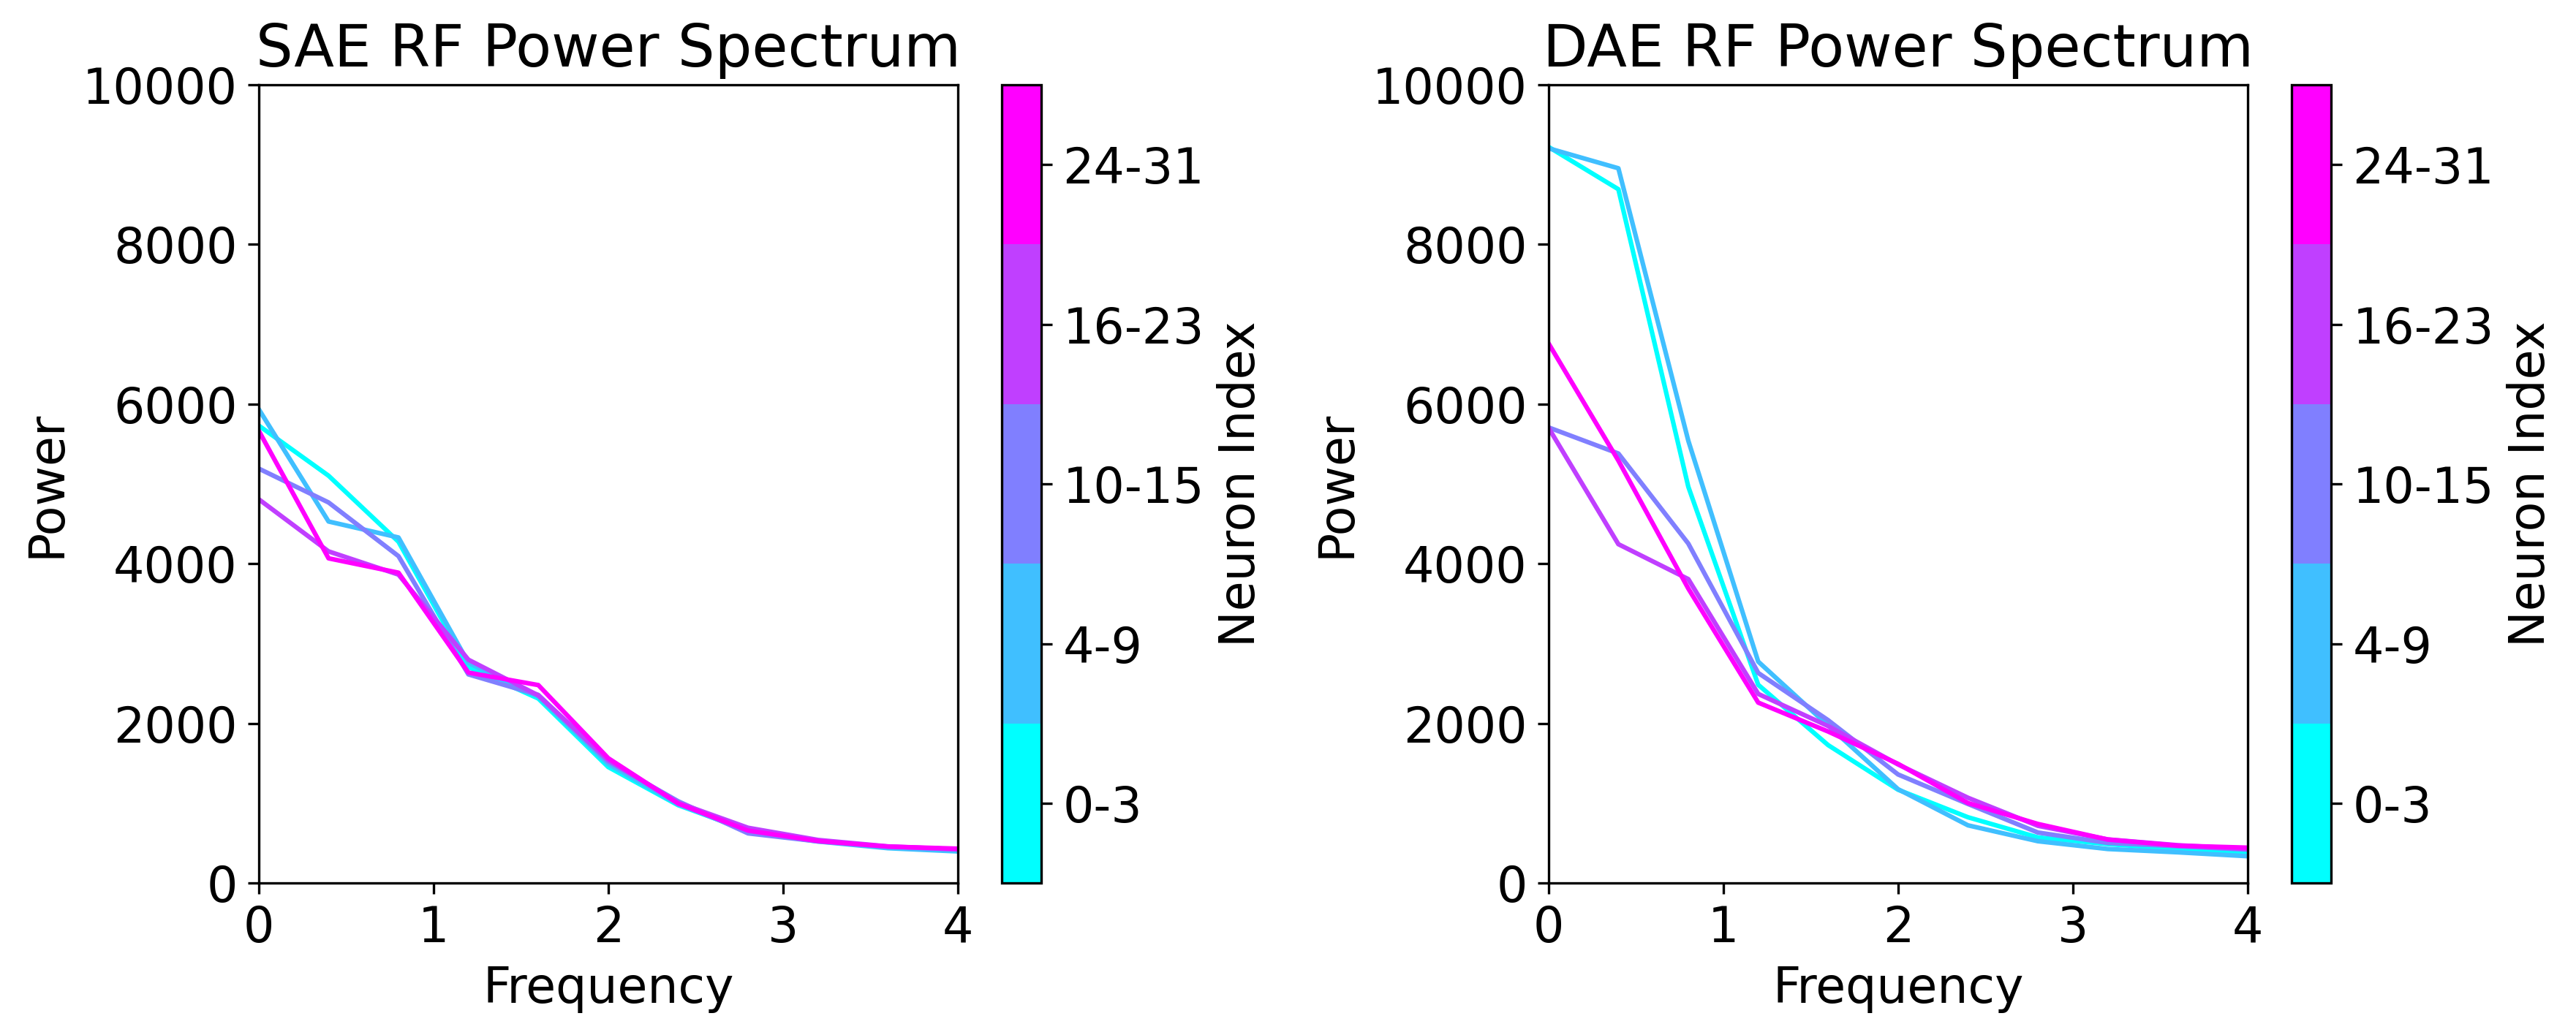

In [26]:
def plot_power_spectra_subplot(ax, frequency_data, title):
    colors = plt.cm.cool(np.linspace(0, 1, 5))
    discrete_cmap = mcolors.ListedColormap(colors)
    bounds = np.arange(-0.5, 5.5, 1)
    
    for idx, freq in enumerate(frequency_data):
        ax.plot(freq, color=colors[idx], label=f'RF{idx + 1}')
    
    ax.set(xlabel='Frequency', 
           ylabel='Power',
           xlim=(0, 10),
           ylim=(0, 10000))
    
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.xticks = [0, 1, 2, 3, 4, 5]
    ax.set_xticklabels([0, 1, 2, 3, 4, 5])
    ax.set_title(title)
    
    norm = mcolors.BoundaryNorm(bounds, discrete_cmap.N)
    sm = plt.cm.ScalarMappable(cmap=discrete_cmap, norm=norm)
    sm.set_array([])
    
    cbar = plt.colorbar(sm, ax=ax, ticks=[0, 1, 2, 3, 4])
    cbar.set_ticklabels(['0-3', '4-9', '10-15', '16-23', '24-31'])
    cbar.set_label('Neuron Index', fontsize=16)
    cbar.ax.tick_params(labelsize=16)
    cbar.minorticks_off()

plt.rcParams['font.size'] = 16
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=300)

plot_power_spectra_subplot(axs[0], np.mean(sae_power_spectra, axis=0), 'SAE RF Power Spectrum')
plot_power_spectra_subplot(axs[1], np.mean(dae_power_spectra, axis=0), 'DAE RF Power Spectrum')

plt.tight_layout()
plt.savefig('Plots_png/combined_rf_power_spectrum.png', bbox_inches='tight', dpi=300)
plt.savefig('Plots_svg/combined_rf_power_spectrum.svg', bbox_inches='tight')
plt.show()